<a href="https://colab.research.google.com/github/felipemaiapolo/hands-on_ic_ml/blob/master/Classifica%C3%A7%C3%A3o_de_Textos_com_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Textos com K-Nearest Neighbors

## Arrumando a casa

In [1]:
!pip install ftfy

In [2]:
#Para o uso geral
import random
import numpy as np
import pandas as pd
import copy 
import time
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
from sklearn.model_selection import train_test_split

#Para o processamento de textos
from ftfy import fix_text
import string
import re
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

Fazendo download dos dados:

In [3]:
%%time

download = requests.get("https://raw.githubusercontent.com/felipemaiapolo/hands-on_ic_ml/master/unsup.csv").content
unsup = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',')

download = requests.get("https://raw.githubusercontent.com/felipemaiapolo/hands-on_ic_ml/master/data_test.csv").content
test = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',')

download = requests.get("https://raw.githubusercontent.com/felipemaiapolo/hands-on_ic_ml/master/data_train.csv").content
train = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',')

CPU times: user 3.05 s, sys: 440 ms, total: 3.49 s
Wall time: 14.6 s


In [4]:
train.shape, test.shape, unsup.shape

((24984, 2), (24985, 2), (49965, 1))

In [5]:
unsup.head()

,review
0,"I admit, the great majority of films released ..."
1,"Take a low budget, inexperienced actors doubli..."
2,"Everybody has seen 'Back To The Future,' right..."
3,Doris Day was an icon of beauty in singing and...
4,"After a series of silly, fun-loving movies, 19..."


In [6]:
train.head()

,review,positive
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [7]:
train.loc[:,'positive'].value_counts()

0    12495
1    12489
Name: positive, dtype: int64

In [8]:
test.loc[:,'positive'].value_counts()

1    12493
0    12492
Name: positive, dtype: int64

## Treinando Representação Vetorial para Textos

Vamos passar nossos textos para o formato de lista:

In [9]:
texts = unsup['review'].to_list()

Checando um texto da lista:

In [10]:
texts[0]

'I admit, the great majority of films released before say 1933 are just not for me. Of the dozen or so "major" silents I have viewed, one I loved (The Crowd), and two were very good (The Last Command and City Lights, that latter Chaplin circa 1931).<br /><br />So I was apprehensive about this one, and humor is often difficult to appreciate (uh, enjoy) decades later. I did like the lead actors, but thought little of the film.<br /><br />One intriguing sequence. Early on, the guys are supposed to get "de-loused" and for about three minutes, fully dressed, do some schtick. In the background, perhaps three dozen men pass by, all naked, white and black (WWI ?), and for most, their butts, part or full backside, are shown. Was this an early variation of beefcake courtesy of Howard Hughes?'

Definindo uma função para a limpeza e padronização dos textos:

In [14]:
def clean(text):
    txt=text.replace("<br />"," ") #retirando tags
    txt=re.sub('\d', ' ', txt) #Tirando números
    txt=fix_text(txt) #consertando Mojibakes (Ver https://pypi.org/project/ftfy/)
    txt=txt.lower() #passando tudo para minúsculo
    txt=txt.translate(str.maketrans('', '', string.punctuation)) #retirando toda pontuação
    txt=txt.replace(" — ", " ") #retirando hífens
    txt=re.sub(' +', ' ', txt) #deletando espaços extras
    return txt

Limpando cada um dos textos:

In [15]:
%%time
texts=[clean(t) for t in texts]

CPU times: user 34.7 s, sys: 33.8 ms, total: 34.7 s
Wall time: 34.7 s


Checando o mesmo texto de forma limpa:

In [16]:
texts[0]

'i admit the great majority of films released before say are just not for me of the dozen or so major silents i have viewed one i loved the crowd and two were very good the last command and city lights that latter chaplin circa so i was apprehensive about this one and humor is often difficult to appreciate uh enjoy decades later i did like the lead actors but thought little of the film one intriguing sequence early on the guys are supposed to get deloused and for about three minutes fully dressed do some schtick in the background perhaps three dozen men pass by all naked white and black wwi and for most their butts part or full backside are shown was this an early variation of beefcake courtesy of howard hughes'

Tokenizando os textos:

In [17]:
%%time
tokens=[t.split() for t in texts]

CPU times: user 945 ms, sys: 435 ms, total: 1.38 s
Wall time: 1.38 s


Visualizando texto tokenizado:

In [18]:
tokens[0]

['i',
 'admit',
 'the',
 'great',
 'majority',
 'of',
 'films',
 'released',
 'before',
 'say',
 'are',
 'just',
 'not',
 'for',
 'me',
 'of',
 'the',
 'dozen',
 'or',
 'so',
 'major',
 'silents',
 'i',
 'have',
 'viewed',
 'one',
 'i',
 'loved',
 'the',
 'crowd',
 'and',
 'two',
 'were',
 'very',
 'good',
 'the',
 'last',
 'command',
 'and',
 'city',
 'lights',
 'that',
 'latter',
 'chaplin',
 'circa',
 'so',
 'i',
 'was',
 'apprehensive',
 'about',
 'this',
 'one',
 'and',
 'humor',
 'is',
 'often',
 'difficult',
 'to',
 'appreciate',
 'uh',
 'enjoy',
 'decades',
 'later',
 'i',
 'did',
 'like',
 'the',
 'lead',
 'actors',
 'but',
 'thought',
 'little',
 'of',
 'the',
 'film',
 'one',
 'intriguing',
 'sequence',
 'early',
 'on',
 'the',
 'guys',
 'are',
 'supposed',
 'to',
 'get',
 'deloused',
 'and',
 'for',
 'about',
 'three',
 'minutes',
 'fully',
 'dressed',
 'do',
 'some',
 'schtick',
 'in',
 'the',
 'background',
 'perhaps',
 'three',
 'dozen',
 'men',
 'pass',
 'by',
 'all',
 

## Doc2Vec

Vamos fazer uma breve introdução ao modelo **Doc2Vec** para a a geração de representações de textos (embeddings) de uma forma fácil e rápida. O modelo **Doc2Vec** é do ano de 2014 e foi descrito pela primeira por pesquisadores do Google no artigo [1] - as imagens utilizadas a seguir foram retiradas deste artigo. Um tutorial bem didático de como a técnica funciona pode ser acessado no link [2] e a documentação do método está em [3]. Antes de explicar como é o funcionamento do modelo **Doc2Vec** é necessário entender como o modelo **Word2Vec**, para o cálculo de representações para palavras, funciona. O modelo **Word2Vec** é um modelo que gera representações vetoriais para palavras de acordo com os contextos em que as palavras aparecem nos textos da nossa base de dados. Dessa maneira é possível pensar que a palavra 'rei' está para 'homem' assim como 'rainha' está para 'mulher' como na figura abaixo:

<figure>
<center>
<img src='https://raw.githubusercontent.com/felipemaiapolo/hands-on_ic_ml/master/word2vec.png' />
</center>
</figure>

É impressionante ver o poder de uma técnica relativamente simples que é o **Word2Vec**. Existem basicamente duas versões de modelos para o **Word2Vec**, a COBW (Continuous Bag of Words) e Skip-Gram - aqui focaremos basicamente na primeira abordagem. A abordagem COBW considera que a posição das palavras podem ser preditas pelo contextos nas quais estão inseridas (palavras no entorno). Chamamos esse contexto de 'janela'. Todas as palavras do vocabulário começam ccom uma representação aleatória que o modelo melhora de acordo com o processo de aprendiagem ao tentar inferir a presença de palavras pelos contextos nos quais estão inseridas. Assim cada palavra adquire uma representação compatível com os contextos em que geralmente essa palavra aparece. Temos então o seguinte esquema para uma implementação do **Word2Vec** COBW:

<figure>
<center>
<img src='https://raw.githubusercontent.com/felipemaiapolo/hands-on_ic_ml/master/word2vec2.png' />
</center>
</figure>

Agora que entendemos um pouco melhor como funciona o modelo **Word2Vec**, podemos entender como é o funcionamento do **Doc2Vec**. O segundo modelo acaba sendo uma extensão do primeiro. Assim como o **Word2Vec**, o modelo **Doc2Vec** tem duas versões principais e aqui focaremos naquela análoga ao COBW, que se chama PV-DM (Distributed Memory version of Paragraph Vector). A ideia continua igual, no entanto adicionamos um vetor específico para cada um dos documentos afim de predizer as palavras daquele documento específico. Assim, parte da informação que não capturada pelas representações das palavras é aprendida pelas representações dos textos. Quando formos treinar o modelo **Doc2vec** basta fornecermos os parâmetros 'window' (para o tamanho da janela) e 'size' para o tamanho dos embeddings (representações dos textos).


<figure>
<center>
<img src='https://raw.githubusercontent.com/felipemaiapolo/hands-on_ic_ml/master/doc2vec.png' />
</center>
</figure>

Fontes:

1. https://cs.stanford.edu/~quocle/paragraph_vector.pdf
2. https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
3. https://radimrehurek.com/gensim/models/doc2vec.html

Especificando hiperparâmetros para treinar modelo Doc2Vec. Neste caso 'window' se refere à distância máxima (em número de palavras) entre as palavras a serem inferidas e aquelas consideradas de contexto.

In [19]:
size=50
window=15

Treinando modelo:

In [20]:
%%time

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens)]
model_doc = Doc2Vec(documents, vector_size=size, window=window, dm_mean=1)

CPU times: user 4min 46s, sys: 3.69 s, total: 4min 49s
Wall time: 2min 43s


A inferência do vetor para um texto específico é feita utilizando a descida pela gradiente, congelando a rede neural do Doc2Vec e atualizando somente os pesos referentes ao novo texto. Na função abaixo, fixamos uma semente (*seed*) afim de garantir resultados reprodutíveis e definimos que a descida pelo gradiente dê 20 passos:

Definindo função que fará o embedding:

In [21]:
def emb(txt, model, normalize=False): 
    model.random.seed(42)
    x=model.infer_vector(txt, steps=20)
    
    if normalize: return(x/np.sqrt(x@x))
    else: return(x)

Aplicando o embedding em um texto tokenizado:

In [22]:
emb(tokens[0], model_doc)

array([-0.64918804,  0.01235389,  0.3738711 , -0.03302976,  0.1006958 ,
       -0.55104595,  0.3519207 ,  0.21948446,  0.65017265,  0.20942628,
       -0.47931373, -0.30971354, -0.6168575 ,  0.16552761,  0.39674568,
        0.40080225,  0.3122229 ,  0.6423478 ,  0.3923607 ,  0.393265  ,
       -0.03936243, -0.60128134,  0.06193454, -0.14824298,  0.19015118,
        0.11555053, -0.78340125,  0.02718775,  0.20121841, -0.4251931 ,
       -0.3180211 ,  0.47743732,  0.01107549, -0.88365513,  0.92716074,
       -0.21524629,  0.76256037, -0.39751282,  0.23216116, -0.6387404 ,
       -0.9219434 , -0.38397217,  0.2235182 , -0.85852826,  0.49178094,
       -0.5513266 , -0.04418961,  0.06922524,  0.10248178,  0.20064338],
      dtype=float32)

## Similaridade entre textos

No contexto de NLP é comum utilizarmos a similaridade de cossenos para compararmos dois textos. É importante recordar que em nosso contexto, cada um dos textos é tratado como um vetor com comprimento, direção e sentido. Um vetor será expresso aqui na forma de matrizes unidimensionais (Numpy arrays). Um vetor de tamanho $n$ é uma lista de valores em forma matricial da seguinte forma:

\begin{equation}
  \begin{aligned}
      \mathbf{x}=\begin{pmatrix} x_1 
      \\ x_2
      \\ ...
      \\ x_n
     \end{pmatrix}
   \end{aligned}
\end{equation}

Assumindo que outro vetor $\mathbf{y}$ tenha o mesmo tamanho de $\mathbf{x}$, o cosseno do ângulo ($\theta$) entre os vetores é calculado da seguinte forma:

\begin{equation}
  \begin{aligned}
      cos(\theta)=\frac{\sum_{i=1}^{n}x_iy_i }{\sqrt{\sum_{i=1}^{n}x_i^2}\sqrt{\sum_{i=1}^{n}y_i^2}}=
      \frac{\mathbf{x}^T\mathbf{y}}{\sqrt{\mathbf{x}^T\mathbf{x}}.\sqrt{\mathbf{y}^T\mathbf{y}}}=
      \frac{\mathbf{x}^T\mathbf{y}}{\left \| \mathbf{x} \right \|.\left \| \mathbf{y} \right \|}
   \end{aligned}
\end{equation}

Se o comprimento dos vetores $\mathbf{y}$ e $\mathbf{x}$ é um, então podemos reescrever o cosseno da seguinte forma:

\begin{equation}
  \begin{aligned}
      cos(\theta)=\sum_{i=1}^{n}x_iy_i=
      \mathbf{x}^T\mathbf{y}
   \end{aligned}
\end{equation}

Para normalizar um vetor $\mathbf{x}$ para que tenha comprimento 1, basta fazer a seguinte atualização:

\begin{equation}
  \begin{aligned}
      \mathbf{x}\leftarrow \frac{\mathbf{x}}{\sqrt{\mathbf{x}^T\mathbf{x}}}
   \end{aligned}
\end{equation}

### Exemplo

Definindo função que calcula a similaridade entre dois vetores. A similaridade (cosseno) varia de -1 a 1 sendo que valores positivos tem sentido parecidos e valores negativos nos dão sentidos opostos:

In [23]:
def simil(x,y):
    return((x@y)/np.sqrt((x@x)*(y@y)))

Definindo dois vetores e os visualizando:

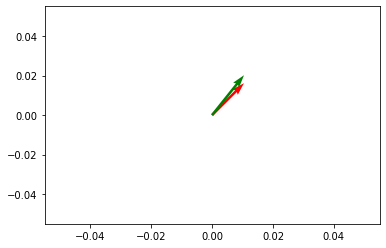

In [24]:
v1=np.array([2,2])
v2=np.array([2,2.5])

V = np.array([v1,v2])

O=np.array([[0],[0]])
plt.quiver(O[:],O[:],V[:,0],V[:,1], color=['r','g','b'], scale=21)
plt.show()

Veja que o menor ângulo entre os vetores é pequeno então a similaridade deve dar algo próximo de 1:

In [25]:
simil(v1,v2)

0.9938837346736188

Veja que o cosseno entre os vetores não depende do tamanho dos vetores. Vamos manter o ângulo mas diminuindo o tamanho do vetor vermelho:

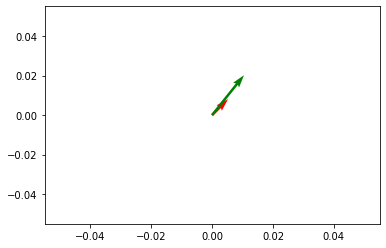

In [26]:
v1=np.array([1,1])
v2=np.array([2,2.5])

V = np.array([v1,v2])

O=np.array([[0],[0]])
plt.quiver(O[:],O[:],V[:,0],V[:,1], color=['r','g','b'], scale=21)
plt.show()

Veja que a medida de similaridade não mudou:

In [27]:
simil(v1,v2)

0.9938837346736188

Se os vetores formam 90 graus entre si, temos que eles são ortogonais (não tem similaridade alguma entre si):

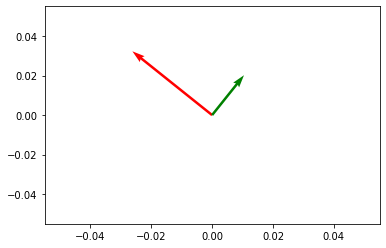

In [28]:
v1=np.array([-5,4])
v2=np.array([2,2.5])

V = np.array([v1,v2])

O=np.array([[0],[0]])
plt.quiver(O[:],O[:],V[:,0],V[:,1], color=['r','g','b'], scale=21)
plt.show()

Calculando a similaridade:

In [29]:
simil(v1,v2)

0.0

Já se o menor ângulo entre os vetores é maior que 90 graus, ou seja, os vetores estão 'apontando' para sentidos opostos, a similaridade é negativa:

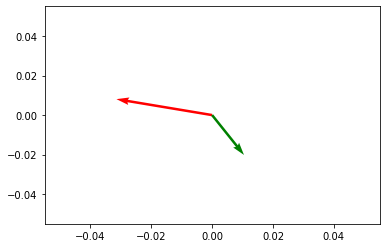

In [30]:
v1=np.array([-6,1])
v2=np.array([2,-2.5])

V = np.array([v1,v2])

O=np.array([[0],[0]])
plt.quiver(O[:],O[:],V[:,0],V[:,1], color=['r','g','b'], scale=21)
plt.show()

Similaridade:

In [31]:
simil(v1,v2)

-0.7445694406464903

## Hands-on

Arrumando bases de dados:

In [32]:
%%time
y_train = np.array(train.loc[:,'positive'].tolist())
X_train = [clean(t).split() for t in train.loc[:,'review'].tolist()]
X_train = np.array([emb(t, model_doc, normalize=True) for t in X_train])

CPU times: user 4min 43s, sys: 435 ms, total: 4min 43s
Wall time: 4min 44s


In [33]:
X_train.shape, y_train.shape

((24984, 50), (24984,))

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_val.shape

((18738, 50), (6246, 50))

Vamos calcular as similaridades entre os textos da base de treino e da base de validação. Para isso, faremos uma multiplicação de matrizes, sendo que a matriz que resulta dessa multiplicação terá suas linhas indexadas aos textos da base de validação e as suas colunas indexadas aos textos da base de treino:

In [35]:
S = X_val@X_train.T

S.shape

(6246, 18738)

Vamos 'recortar' um pedaço dessa matriz e visualizá-la na forma de um heatmap:

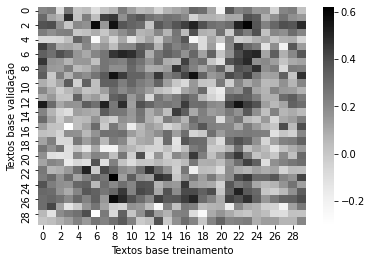

In [40]:
sns.heatmap(S[:30,:30], cmap="Greys")

plt.ylabel('Textos base validação')
plt.xlabel('Textos base treinamento')
plt.show()

### TO-DO

- Achar os $k=5$ textos mais similares na base de treino para todos os textos da base de validação. Após achar os $k$ textos mais similares, criar uma predição para o rótulo de cada linha da base de validação seguindo a regra "se a proporção positivos nas amostras próximas for maior ou igual a 1/2, então classificar linha como positiva. Caso contrário, classificar linha como negativa";

  - Dica 1: utilizar multiplicação de matrizes;
  - Dica 2: utilizar função 'argsort' do pacote Numpy. 

- Determinar $k^* \in \{1,5,10,25,50,100,500,1000,5000,10000\}$ que maximiza a acurácia (#acertos/#total) no conjunto de validação

- Combinar conjunto de treino e validação e, utilizando $k^*$, determinar acurácia no conjunto de teste;

In [41]:
x=np.array([[1,0,9,-2],[3,4,2,5],[-1,4,6,5]])
x

array([[ 1,  0,  9, -2],
       [ 3,  4,  2,  5],
       [-1,  4,  6,  5]])

In [42]:
k=3
x.argsort(axis=1)[:,::-1][:,:k]

array([[2, 0, 1],
       [3, 1, 0],
       [2, 3, 1]])